# Deep Learning - Minor 2 

    Ayush Abrol B20AI052

---

## Question - 1

- DD/MM/YY = 18/03/02
- ABC = 052
- FIRST = AYUSH
- LAST = ABROL
- PROG = B20AI

Training a Student-Teacher model with the following details:

1. **Dataset** - CIFAR-10
2. **Weight Initialization** - He
3. **Pooling** - Max Pooling
4. **Model Details**:
    1. **Teacher Network** - 7 conv layers, 1 pool layer with 6 filters in the first layer, 1 FC layer with 256 nodes.
    2. **Student Network** - 2 conv layers, 1 pool layer, 1 FC layer with 256 nodes.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch
import torchvision
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import PIL
from torchvision.utils import save_image
import warnings
warnings.filterwarnings('ignore')

### Loading the CIFAR-10 dataset and normalizing it

In [74]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [75]:
train_loader = torch.utils.data.DataLoader(  
    datasets.CIFAR10('data', train=True, download=True,
                        transform=train_transform),
    batch_size=128, shuffle=True) # 128 is the batch size

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=test_transform),
    batch_size=128, shuffle=False)  

Files already downloaded and verified


In [76]:
X_train = train_loader.dataset.data # 50000 images
y_train = np.array(train_loader.dataset.targets) # 50000 labels
X_test = test_loader.dataset.data # 10000 images
y_test = np.array(test_loader.dataset.targets) # 10000 labels

print("Train data shape: ", X_train.shape) 
print("Test data shape: ", X_test.shape)

print("Train data labels shape: ", y_train.shape)
print("Test data labels shape: ", y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
Train data labels shape:  (50000,)
Test data labels shape:  (10000,)


In [77]:
classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

### Visualizing the dataset

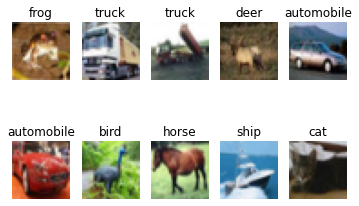

In [78]:
for i in range(10): 
    plt.subplot(2,5,i+1) 
    plt.imshow(X_train[i]) # Displaying the image
    plt.title(classes[y_train[i]]) # Displaying the label
    plt.axis('off')

### Creating dataloaders which are compatible with PyTorch

In [79]:
def create_dataloader(x_train, y_train, x_test, y_test):
    x_train, x_test, y_train, y_test = torch.Tensor(x_train).permute(0, 3, 1, 2), torch.Tensor(x_test).permute(0, 3, 1, 2), torch.Tensor(y_train), torch.Tensor(y_test)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle = True)

    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle = False)

    return trainloader, testloader

trainloader, testloader = create_dataloader(X_train, y_train, X_test, y_test)

torch.Size([50000, 3, 32, 32]) torch.Size([50000]) torch.Size([10000, 3, 32, 32]) torch.Size([10000])


### Setting the environment to GPU

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

### Initializing the Teacher Model Class with the required parameters

In [81]:
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(12, 24, 3, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(24, 48, 3, padding=1)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.conv5 = nn.Conv2d(48, 96, 3, padding=1)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.conv6 = nn.Conv2d(96, 192, 3, padding=1)
        nn.init.kaiming_normal_(self.conv6.weight)
        self.conv7 = nn.Conv2d(192, 384, 3, padding=1)
        nn.init.kaiming_normal_(self.conv7.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(384 * 16 * 16, 256)
        nn.init.kaiming_normal_(self.fc.weight)
        self.fc_out = nn.Linear(256, 10)
        nn.init.kaiming_normal_(self.fc_out.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool(x)
        x = x.view(-1, 384 * 16 * 16)
        x = F.relu(self.fc(x))
        x = self.fc_out(x)
        return x

### Instantiating the Teacher Model with Cross Entropy Loss and Adam Optimizer to train the teacher model

In [82]:
teacher = TeacherModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher.parameters(), lr=0.001)

### Defining the training loop for the teacher model

In [83]:
def train_model(model, optimizer, epochs, train_loss, train_accuracy):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss/len(trainloader)
        avg_accuracy = correct/len(trainloader.dataset)
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        print("Epoch:", epoch+1, "Training Loss: ", avg_loss, "\t Training Accuracy: ", avg_accuracy)
    return train_loss, train_accuracy

### Training the teacher model for 20 epochs 

In [28]:
train_loss_teacher = []
train_accuracy_teacher = []
train_loss_teacher, train_accuracy_teacher = train_model(teacher, optimizer, 10, train_loss_teacher, train_accuracy_teacher)
print("Training Complete for Teacher Model")

Epoch: 1 Training Loss:  59.3785232823828 	 Training Accuracy:  0.24658
Epoch: 2 Training Loss:  1.871787279158297 	 Training Accuracy:  0.30952
Epoch: 3 Training Loss:  1.7614213542255295 	 Training Accuracy:  0.3564
Epoch: 4 Training Loss:  1.6606790854802826 	 Training Accuracy:  0.39844
Epoch: 5 Training Loss:  1.5033126188361126 	 Training Accuracy:  0.46012
Epoch: 6 Training Loss:  1.334820045534607 	 Training Accuracy:  0.52328
Epoch: 7 Training Loss:  1.1880343233228035 	 Training Accuracy:  0.57758
Epoch: 8 Training Loss:  1.0656714410428196 	 Training Accuracy:  0.62134
Epoch: 9 Training Loss:  0.9298708845892221 	 Training Accuracy:  0.67156
Epoch: 10 Training Loss:  0.7656422842036733 	 Training Accuracy:  0.73096
Training Complete for Teacher Model


In [30]:
print("Training for additional 10 epochs")
train_loss_teacher, train_accuracy_teacher = train_model(teacher, optimizer, 10, train_loss_teacher, train_accuracy_teacher)
print("Training Complete for Teacher Model with total 20 epochs")

Training for additional 10 epochs
Epoch: 11 Training Loss:  0.6104397587763989 	 Training Accuracy:  0.78626
Epoch: 12 Training Loss:  0.47475555257114305 	 Training Accuracy:  0.83548
Epoch: 13 Training Loss:  0.381651756975352 	 Training Accuracy:  0.86714
Epoch: 14 Training Loss:  0.29945904153692143 	 Training Accuracy:  0.89738
Epoch: 15 Training Loss:  0.2795521038610612 	 Training Accuracy:  0.90584
Epoch: 16 Training Loss:  0.24246648681895508 	 Training Accuracy:  0.91824
Epoch: 17 Training Loss:  0.22963857193432197 	 Training Accuracy:  0.92514
Epoch: 18 Training Loss:  0.2243217466318089 	 Training Accuracy:  0.9278
Epoch: 19 Training Loss:  0.20362323245314687 	 Training Accuracy:  0.9337
Epoch: 20 Training Loss:  0.17449226268493306 	 Training Accuracy:  0.94446
Training Complete for Teacher Model with total 20 epochs


### Saving the teacher model's trained weights

In [32]:
# Saving the teacher model
torch.save(teacher.state_dict(), 'teacher_model.pth')

### Loading the teacher model's trained weights

In [84]:
# Loading the teacher model
teacher.load_state_dict(torch.load('teacher_model.pth'))

<All keys matched successfully>

### Plotting the training loss and accuracy of the teacher model 

NameError: name 'train_loss_teacher' is not defined

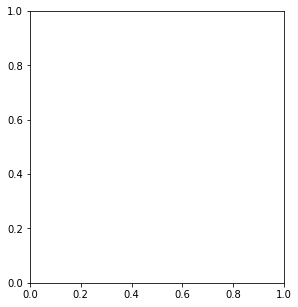

In [85]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_teacher[1:])
plt.title("Training Loss for Teacher Model")
plt.subplot(1,2,2)
plt.plot(train_accuracy_teacher[1:])
plt.title("Training Accuracy for Teacher Model")

### Initializing the Student Model Class with the required parameters|

In [86]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 16 * 16, 256)
        nn.init.kaiming_normal_(self.fc.weight)
        self.fc_out = nn.Linear(256, 10)
        nn.init.kaiming_normal_(self.fc_out.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc(x))
        x = self.fc_out(x)
        return x

In [87]:
student = StudentModel().to(device)
optimizer = optim.Adam(student.parameters(), lr=0.001)

### Backpropagating both the losses (Knowledge Distillation and Cross Entropy)

In [88]:
def distillation_loss(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss()(F.log_softmax(y/T, dim=1), F.softmax(teacher_scores/T, dim=1)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)

In [89]:
def train_model_distillation(model, teacher, optimizer, epochs, distillation_loss, train_loss, train_accuracy):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(inputs)
            teacher_outputs = teacher(inputs)
            loss = distillation_loss(outputs, labels.long(), teacher_outputs, 20, 0.5)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss/len(trainloader)
        avg_accuracy = correct/len(trainloader.dataset)
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        print("Epoch:", epoch+1, "Training Loss: ", avg_loss, "\t Training Accuracy: ", avg_accuracy)
    return train_loss, train_accuracy

In [49]:
train_loss_student = []
train_accuracy_student = []
train_loss_student, train_accuracy_student = train_model_distillation(student, teacher, optimizer, 20, distillation_loss, train_loss_student, train_accuracy_student)

Epoch: 1 Training Loss:  227.08311822896113 	 Training Accuracy:  0.27036
Epoch: 2 Training Loss:  4.184126938700371 	 Training Accuracy:  0.44048
Epoch: 3 Training Loss:  3.6282898958991554 	 Training Accuracy:  0.51682
Epoch: 4 Training Loss:  3.239944373860079 	 Training Accuracy:  0.56976
Epoch: 5 Training Loss:  2.910828540392239 	 Training Accuracy:  0.6205
Epoch: 6 Training Loss:  2.640123134988653 	 Training Accuracy:  0.66354
Epoch: 7 Training Loss:  2.3888958543157943 	 Training Accuracy:  0.70624
Epoch: 8 Training Loss:  2.176407312188307 	 Training Accuracy:  0.74194
Epoch: 9 Training Loss:  1.988972645891292 	 Training Accuracy:  0.77464
Epoch: 10 Training Loss:  1.8309496119808968 	 Training Accuracy:  0.80288
Epoch: 11 Training Loss:  1.68374017071541 	 Training Accuracy:  0.8317
Epoch: 12 Training Loss:  1.5543009984828626 	 Training Accuracy:  0.8542
Epoch: 13 Training Loss:  1.4613446027726469 	 Training Accuracy:  0.87136
Epoch: 14 Training Loss:  1.3793550177913187 

Text(0.5, 1.0, 'Training Accuracy for Student Model trained with distillation loss + cross entropy loss')

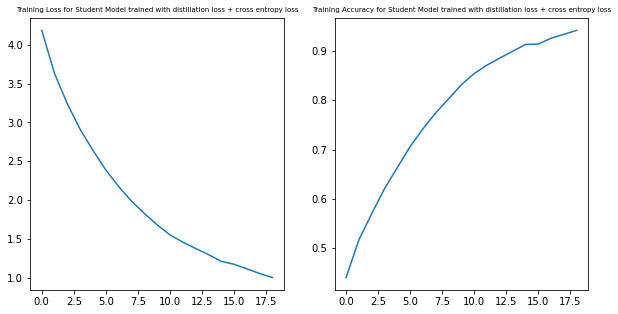

In [61]:
# Plotting the training loss and accuracy for student model trained with distillation loss + cross entropy loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_student[1:])
plt.title("Training Loss for Student Model trained with distillation loss + cross entropy loss", fontsize=7)
plt.subplot(1,2,2)
plt.plot(train_accuracy_student[1:])
plt.title("Training Accuracy for Student Model trained with distillation loss + cross entropy loss", fontsize=7)

In [51]:
# Saving the student model with distillation + Cross Entropy Loss
torch.save(student.state_dict(), 'student_model.pth')

In [90]:
# Loading the student model with distillation + Cross Entropy Loss
student.load_state_dict(torch.load('student_model.pth'))

<All keys matched successfully>

### Backpropagating only the Knowledge Distillation loss and training the Student Network again

In [91]:
student_ex = StudentModel().to(device)
optimizer = optim.Adam(student_ex.parameters(), lr=0.001)

In [92]:
# Train the student model using knowledge distillation from the teacher model
def distillation_loss_ex(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss()(F.log_softmax(y/T, dim=1), F.softmax(teacher_scores/T, dim=1)) * (T*T * 2.0 * alpha)

In [21]:
train_loss_student_ex = []
train_accuracy_student_ex = []
train_loss_student_ex, train_accuracy_student_ex = train_model_distillation(student_ex, teacher, optimizer, 20, distillation_loss_ex, train_loss_student_ex, train_accuracy_student_ex)
print("Training Complete for Student Model with Knowledge Distillation alone")

Epoch: 1 Training Loss:  129.23436660290983 	 Training Accuracy:  0.30932
Epoch: 2 Training Loss:  3.070730686187744 	 Training Accuracy:  0.42688
Epoch: 3 Training Loss:  2.6408093682945233 	 Training Accuracy:  0.47808
Epoch: 4 Training Loss:  2.3026988930104637 	 Training Accuracy:  0.52238
Epoch: 5 Training Loss:  2.024811822130247 	 Training Accuracy:  0.5601
Epoch: 6 Training Loss:  1.811858680547046 	 Training Accuracy:  0.59276
Epoch: 7 Training Loss:  1.620711183304067 	 Training Accuracy:  0.62138
Epoch: 8 Training Loss:  1.4806955406427993 	 Training Accuracy:  0.64428
Epoch: 9 Training Loss:  1.3605031689719471 	 Training Accuracy:  0.66652
Epoch: 10 Training Loss:  1.2618382775875003 	 Training Accuracy:  0.68728
Epoch: 11 Training Loss:  1.1894035380514687 	 Training Accuracy:  0.6994
Epoch: 12 Training Loss:  1.108454874104551 	 Training Accuracy:  0.71514
Epoch: 13 Training Loss:  1.049187261735082 	 Training Accuracy:  0.7271
Epoch: 14 Training Loss:  1.001083311217520

In [35]:
# Saving the student model with distillation loss alone
torch.save(student_ex.state_dict(), 'student_model_ex.pth')

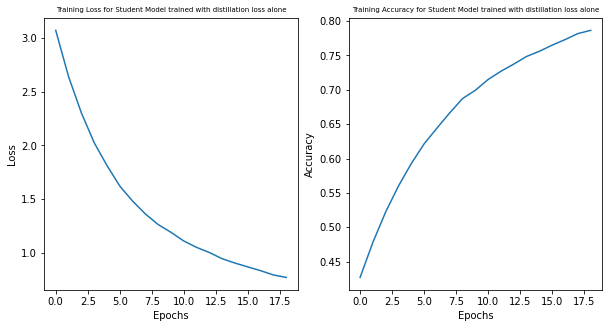

In [22]:
# Plotting the training loss and accuracy for student model trained with distillation loss alone
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_student_ex[1:])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss for Student Model trained with distillation loss alone", fontsize=7)
plt.subplot(1,2,2)
plt.plot(train_accuracy_student_ex[1:])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy for Student Model trained with distillation loss alone", fontsize=7)
plt.show()

In [93]:
def test(model, testloader, device):
    test_loss = []
    test_accuracy = []
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels.long())
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss/len(testloader)
        avg_accuracy = correct/len(testloader.dataset)
        test_loss.append(avg_loss)
        test_accuracy.append(avg_accuracy)
        print("Test Loss: ", avg_loss, "\t Test Accuracy: ", avg_accuracy)
    return test_loss, test_accuracy

In [94]:
print("Testing the Teacher Model")
test_loss_teacher, test_accuracy_teacher = test(teacher, testloader, device)

Testing the Teacher Model
Test Loss:  2.8640539434891714 	 Test Accuracy:  0.5406


In [95]:
print("Testing the Student Model with Knowledge Distillation + Cross Entropy Loss")
test_loss_student, test_accuracy_student = test(student, testloader, device)

Testing the Student Model with Knowledge Distillation + Cross Entropy Loss
Test Loss:  3.1186087040961543 	 Test Accuracy:  0.4885


In [27]:
print("Testing the Student Model with Knowledge Distillation Loss alone")
test_loss_student_ex, test_accuracy_student_ex = test(student_ex, testloader, device)

Testing the Student Model with Knowledge Distillation Loss alone
Test Loss:  3.353041597559482 	 Test Accuracy:  0.5058


### Comparing the performance with and without EMA (Exponential Moving Average) updates.

In [53]:
class TeacherModel_EMA(nn.Module):
    def __init__(self):
        super(TeacherModel_EMA, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 16 * 16, 256)
        nn.init.kaiming_normal_(self.fc.weight)
        self.fc_out = nn.Linear(256, 10)
        nn.init.kaiming_normal_(self.fc_out.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc(x))
        x = self.fc_out(x)
        return x

In [54]:
class StudentModel_EMALoss(nn.Module):
    def __init__(self):
        super(StudentModel_EMALoss, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 16 * 16, 256)
        nn.init.kaiming_normal_(self.fc.weight)
        self.fc_out = nn.Linear(256, 10)
        nn.init.kaiming_normal_(self.fc_out.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc(x))
        x = self.fc_out(x)
        return x

In [55]:
student_net = StudentModel_EMALoss().to(device)
teacher_net = TeacherModel_EMA().to(device)
optimizer_student = optim.Adam(student_net.parameters(), lr=0.001)
optimizer_teacher = optim.Adam(teacher_net.parameters(), lr=0.001)

In [56]:
# Training the teacher model with Cross Entropy Loss
train_loss_teacher_ema = []
train_accuracy_teacher_ema = []
train_loss_teacher_ema, train_accuracy_teacher_ema = train_model(teacher_net, optimizer_teacher, 20, train_loss_teacher_ema, train_accuracy_teacher_ema)
print("Training Complete for Teacher Model")

Epoch: 1 Training Loss:  49.99217209273287 	 Training Accuracy:  0.26612
Epoch: 2 Training Loss:  1.6444546145856227 	 Training Accuracy:  0.41482
Epoch: 3 Training Loss:  1.3772063282749536 	 Training Accuracy:  0.51014
Epoch: 4 Training Loss:  1.135602668423177 	 Training Accuracy:  0.59814
Epoch: 5 Training Loss:  0.9089021662921857 	 Training Accuracy:  0.6811
Epoch: 6 Training Loss:  0.7382481717087729 	 Training Accuracy:  0.74604
Epoch: 7 Training Loss:  0.5861750937178921 	 Training Accuracy:  0.79966
Epoch: 8 Training Loss:  0.4755054893700973 	 Training Accuracy:  0.83892
Epoch: 9 Training Loss:  0.4094908462689661 	 Training Accuracy:  0.86314
Epoch: 10 Training Loss:  0.3664587988801625 	 Training Accuracy:  0.87804
Epoch: 11 Training Loss:  0.3155742054781341 	 Training Accuracy:  0.8948
Epoch: 12 Training Loss:  0.26338935188015405 	 Training Accuracy:  0.91516
Epoch: 13 Training Loss:  0.2525375665872908 	 Training Accuracy:  0.9165
Epoch: 14 Training Loss:  0.2726738365

In [57]:
# Testing the teacher model
print("Testing the Teacher Model")
test_loss_teacher_ema, test_accuracy_teacher_ema = test(teacher_net, testloader, device)

Testing the Teacher Model
Test Loss:  5.347061724602422 	 Test Accuracy:  0.4459


In [58]:
def train_w_EMA(student_net, teacher_net, device, trainloader, optimizer, temperature, alpha):
    student_net.train()
    teacher_net.eval()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        student_logits = student_net(inputs)
        teacher_logits = teacher_net(inputs)
        # soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=1)
        # hard_targets = targets
        loss = alpha * distillation_loss(student_logits, targets.long(), teacher_logits, temperature, alpha)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = student_logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Update the teacher network's parameters using EMA
    for teacher_param, student_param in zip(teacher_net.parameters(), student_net.parameters()):
        teacher_param.data.mul_(1 - alpha).add_(alpha * student_param.data)

    return (train_loss / len(trainloader), 100. * correct / total)

In [59]:
def test_w_EMA(student_net, device, testloader):
    student_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            student_logits = student_net(inputs)
            loss = F.cross_entropy(student_logits, targets.long())
            test_loss += loss.item()
            _, predicted = student_logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return (test_loss / len(testloader), 100. * correct / total)

In [60]:
# Train the student network with EMA updates for 20 epochs
train_loss_student_ema = []
train_accuracy_student_ema = []
test_loss_student_ema = []
test_accuracy_student_ema = []
alpha = 0.1
best_test_acc = 0
teacher_net.load_state_dict(student_net.state_dict())  # Initialize the teacher network with the student network's parameters
for epoch in range(20):
    train_loss, train_acc = train_w_EMA(student_net, teacher_net, device, trainloader, optimizer_student, temperature=20, alpha=alpha)
    test_loss, test_acc = test_w_EMA(student_net, device, testloader)
    train_loss_student_ema.append(train_loss)
    train_accuracy_student_ema.append(train_acc)
    test_loss_student_ema.append(test_loss)
    test_accuracy_student_ema.append(test_acc)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(student_net.state_dict(), 'student_net_EMA.pth')
    print(f'Epoch {epoch}: Train Loss={train_loss:.3f}, Train Acc={train_acc:.2f}, Test Loss={test_loss:.3f}, Test Acc={test_acc:.2f}')


Epoch 0: Train Loss=11.563, Train Acc=18.49, Test Loss=2.804, Test Acc=25.52
Epoch 1: Train Loss=1.512, Train Acc=29.69, Test Loss=2.726, Test Acc=30.29
Epoch 2: Train Loss=1.122, Train Acc=37.95, Test Loss=2.525, Test Acc=31.76
Epoch 3: Train Loss=1.490, Train Acc=36.33, Test Loss=3.225, Test Acc=33.08
Epoch 4: Train Loss=1.560, Train Acc=39.44, Test Loss=3.854, Test Acc=37.45
Epoch 5: Train Loss=1.496, Train Acc=43.63, Test Loss=4.452, Test Acc=37.00
Epoch 6: Train Loss=1.377, Train Acc=46.81, Test Loss=5.089, Test Acc=38.09
Epoch 7: Train Loss=1.131, Train Acc=51.61, Test Loss=4.799, Test Acc=38.93
Epoch 8: Train Loss=0.886, Train Acc=56.24, Test Loss=4.680, Test Acc=40.21
Epoch 9: Train Loss=0.685, Train Acc=60.75, Test Loss=4.287, Test Acc=39.18
Epoch 10: Train Loss=0.566, Train Acc=64.48, Test Loss=5.937, Test Acc=42.87
Epoch 11: Train Loss=0.486, Train Acc=67.09, Test Loss=4.692, Test Acc=45.70
Epoch 12: Train Loss=0.411, Train Acc=70.33, Test Loss=5.170, Test Acc=45.55
Epoch 13

In [61]:
# Best test accuracy achieved by the student network
print(f'Best Test Accuracy achieved by the student network with EMA update: {best_test_acc:.2f}')

Best Test Accuracy achieved by the student network with EMA update: 47.24


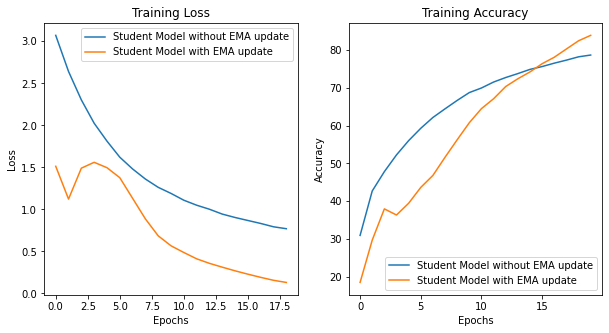

In [72]:
# Comapring the test accuracy of the student network with and without EMA updates
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_student_ex[1:], label='Student Model without EMA update')
plt.plot(train_loss_student_ema[1:], label='Student Model with EMA update')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_student_ex, label='Student Model without EMA update')
plt.plot(train_accuracy_student_ema, label='Student Model with EMA update')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

**END OF MINOR 2 - QUESTION 1**